# This notebook tests the outputs of VESIcal for the Liu et al. (2005) model.
- This notebook relies on the Excel spreadsheet entitled: "Testing_Liu_et_al_2005.xlsx"
- Test 1 compares the experimental pressures in the H$_2$O-only experiments in Tables 2a and 2b from the main text to the saturation pressures obtained from VESIcal for the "LiuWater" model. 
- Test 2 uses a synthetic array of inputs with increasing H$_2$O contents to compare calculated saturation pressures using "LiuWater" to those shown in their Fig. 5 for three different temperatures. 
- Test 3 uses a synthetic array of inputs with increasing CO$_2$ contents using "LiuCarbon" to recreate their Fig. 7. Liu et al. (2005) calibrate their CO$_2$ model based on published data, which they correct using molar absorptivities. Due to uncertainty about the exact carbon contents used for their calibration dataset following this correction, we do not test this model against the calibration dataset.
- Test 4 produces isobars to recreate their Fig. 6. 

In [1]:
import VESIcal as v
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
msp_fontdict = {'family': 'serif',
				 'color': 'darkblue',
				 'weight': 'normal',
				 'size': 18,}

plt.rcParams["font.family"] = 'arial'
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["mathtext.fontset"] = "dejavusans"
plt.style.use("seaborn-colorblind")
mpl.rcParams['patch.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 1 # set the value globally
%matplotlib inline
sns.set(style="ticks", context="poster",rc={"grid.linewidth": 1,"xtick.major.width": 1,"ytick.major.width": 1, 'patch.edgecolor': 'black'})

# Test 1 - Comparing experimental pressures to those calculated from VESIcal

In [3]:
myfile= v.ExcelFile('Testing_Liu_et_al_2005.xlsx',   input_type='wtpercent', sheet_name='Test 1')
data = myfile.data
satPs_wtemps_Liu_Water=myfile.calculate_saturation_pressure(temperature="Temp", model='LiuWater')

## Calculating Linear regressions and plotting data

Text(252, 250, '1:1')

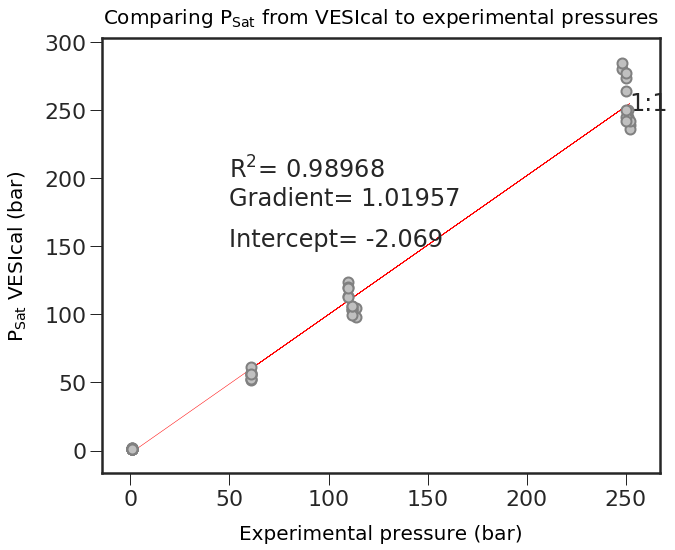

In [4]:
X_Test1=satPs_wtemps_Liu_Water['Press'] # Convert MPa from their supplement to bars
Y_Test1=satPs_wtemps_Liu_Water['SaturationP_bars_VESIcal']
mask_Test1 = (X_Test1>-1) & (Y_Test1>-1) #& (XComb<7000) # This gets rid of Nans
X_Test1noNan=X_Test1[mask_Test1].values.reshape(-1, 1)
Y_Test1noNan=Y_Test1[mask_Test1].values.reshape(-1, 1)
lr=LinearRegression()
lr.fit(X_Test1noNan,Y_Test1noNan)
Y_pred_Test1=lr.predict(X_Test1noNan)

fig, ax1 = plt.subplots(figsize = (10,8)) # adjust dimensions of figure here
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 20,
        }
ax1.set_title('Comparing P$_{Sat}$ from VESIcal to experimental pressures',
        fontdict= font, pad = 15)
plt.xlabel('Experimental pressure (bar)', fontdict=font, labelpad = 15)
plt.ylabel('P$_{Sat}$ VESIcal (bar)', fontdict=font, labelpad = 15)
plt.plot(X_Test1noNan,Y_pred_Test1, color='red', linewidth=0.5, zorder=1) # This plots the best fit line
plt.scatter(satPs_wtemps_Liu_Water['Press'], satPs_wtemps_Liu_Water['SaturationP_bars_VESIcal'],  s=100, edgecolors='gray', facecolors='silver', marker='o', zorder=5)
# This bit plots the regression parameters on the graph
I='Intercept= ' + str(np.round(lr.intercept_, 3))[1:-1]
G='Gradient= '  + str(np.round(lr.coef_, 5))[2:-2]
R='R$^2$= ' +  str(np.round(r2_score(Y_Test1noNan, Y_pred_Test1), 5)) 
one='1:1'
#plt.plot([0, 6000], [0, 6000])
plt.text(50, 150, I)
plt.text(50, 180, G)
plt.text(50, 200, R)
plt.text(252, 250, one)

# Test 2 -Recreating their Fig. 5 using a synthetic array of inputs
- This code was run for 3 temperatures (700, 800 and 1200°C), and overlain on Fig. 5 of Liu et al. (2005) in adobe illustrator (pasted below). 

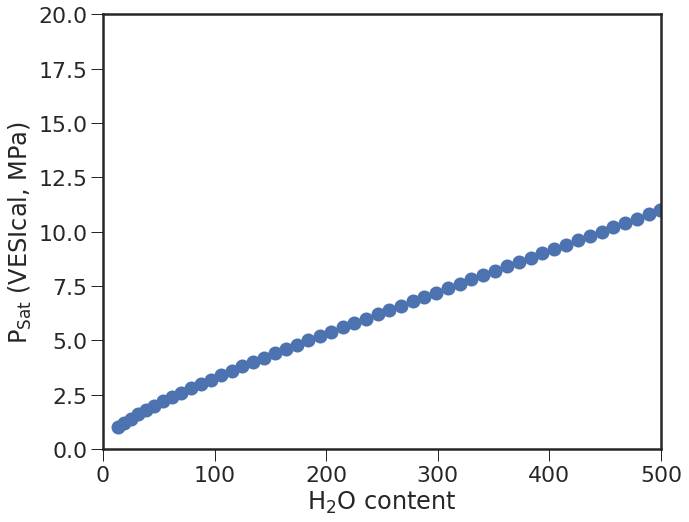

In [5]:
# Example for how curves were generated to overlay on Fig. 5
myfile_syn= v.ExcelFile('Testing_Liu_et_al_2005.xlsx',   input_type='wtpercent', sheet_name='Test 2')
data_syn = myfile_syn.data
satPs_wtemps_Liu_Water_syn=myfile_syn.calculate_saturation_pressure(temperature=1200, model='LiuWater')

fig, ax1 = plt.subplots(figsize = (10,8)) # adjust dimensions of figure here
plt.scatter(0.1*satPs_wtemps_Liu_Water_syn['SaturationP_bars_VESIcal'], satPs_wtemps_Liu_Water_syn['H2O'])
plt.xlim([0, 500])
plt.ylim([0, 20])
plt.xlabel('H$_2$O content')
plt.ylabel('P$_{Sat}$ (VESIcal, MPa)')
plt.yticks()
fig.savefig('1200Ccurves.svg', transparent=True)

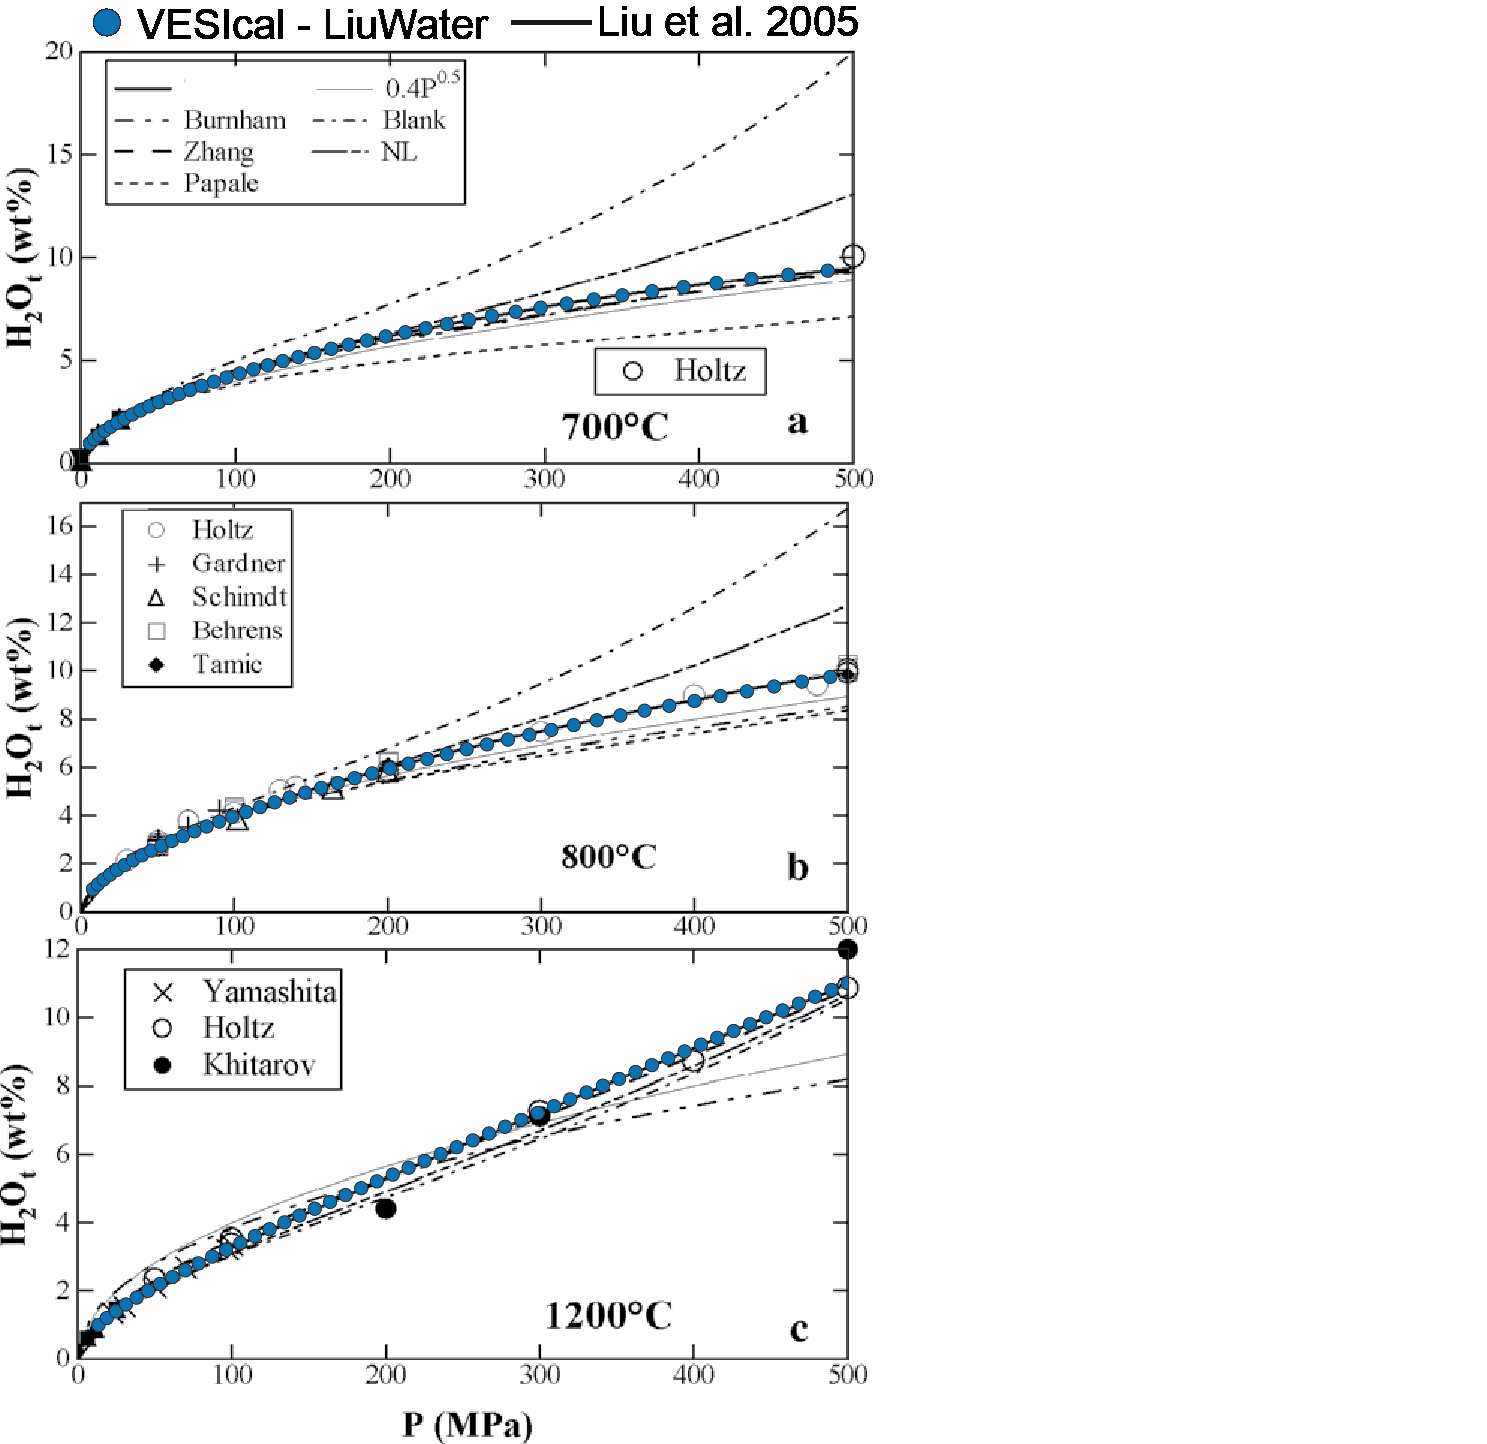


# Test 3 - Recreating their Fig. 7  
- The black line on Fig. 7 represents the output of their Equation 2b for 1050°C. We generate a synthetic anhydrous dataset with varying CO$_2$ contents, and calculate saturation pressures using the Liu et al. (2005) H$_2$O model. These fall perfectly along this line. 

In [6]:
myfile_CO2= v.ExcelFile('Testing_Liu_et_al_2005.xlsx',   input_type='wtpercent', sheet_name='Test 3')
data_CO2 = myfile_CO2.data
data_CO2.head()

,Location,SiO2,TiO2,Al2O3,FeO,MgO,CaO,Na2O,K2O,H2O,CO2,Press,Temp,Fe2O3,Cr2O3,MnO,NiO,CoO,P2O5
Label,,,,,,,,,,,,,,,,,,,
Fogel and Rutherford - CO2,0.0,76.45,0.08,12.56,1.02,0.06,0.25,4.21,4.78,0,0.00,0,1050,0.0,0.0,0.0,0.0,0.0,0.0
Fogel and Rutherford - CO3,0.0,76.45,0.08,12.56,1.02,0.06,0.25,4.21,4.78,0,0.03,0,1050,0.0,0.0,0.0,0.0,0.0,0.0
Fogel and Rutherford - CO4,0.0,76.45,0.08,12.56,1.02,0.06,0.25,4.21,4.78,0,0.06,0,1050,0.0,0.0,0.0,0.0,0.0,0.0
Fogel and Rutherford - CO5,0.0,76.45,0.08,12.56,1.02,0.06,0.25,4.21,4.78,0,0.09,0,1050,0.0,0.0,0.0,0.0,0.0,0.0
Fogel and Rutherford - CO6,0.0,76.45,0.08,12.56,1.02,0.06,0.25,4.21,4.78,0,0.12,0,1050,0.0,0.0,0.0,0.0,0.0,0.0


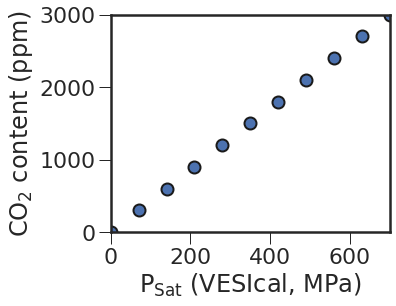

In [7]:
myfile_CO2= v.ExcelFile('Testing_Liu_et_al_2005.xlsx',   input_type='wtpercent', sheet_name='Test 3')
satPs_wtemps_Liu_CO2=myfile_CO2.calculate_saturation_pressure(temperature=1050, model='LiuCarbon')

fig, ax1 = plt.subplots(figsize = (5,4)) # adjust dimensions of figure here
plt.scatter(0.1*satPs_wtemps_Liu_CO2['SaturationP_bars_VESIcal'], 10000*satPs_wtemps_Liu_CO2['CO2'], edgecolor='k')
plt.ylim([0, 3000])
plt.xlim([0, 700])
plt.ylabel('CO$_2$ content (ppm)')
plt.xlabel('P$_{Sat}$ (VESIcal, MPa)')
plt.yticks()
fig.savefig('1050CO2curves.svg', transparent=True)

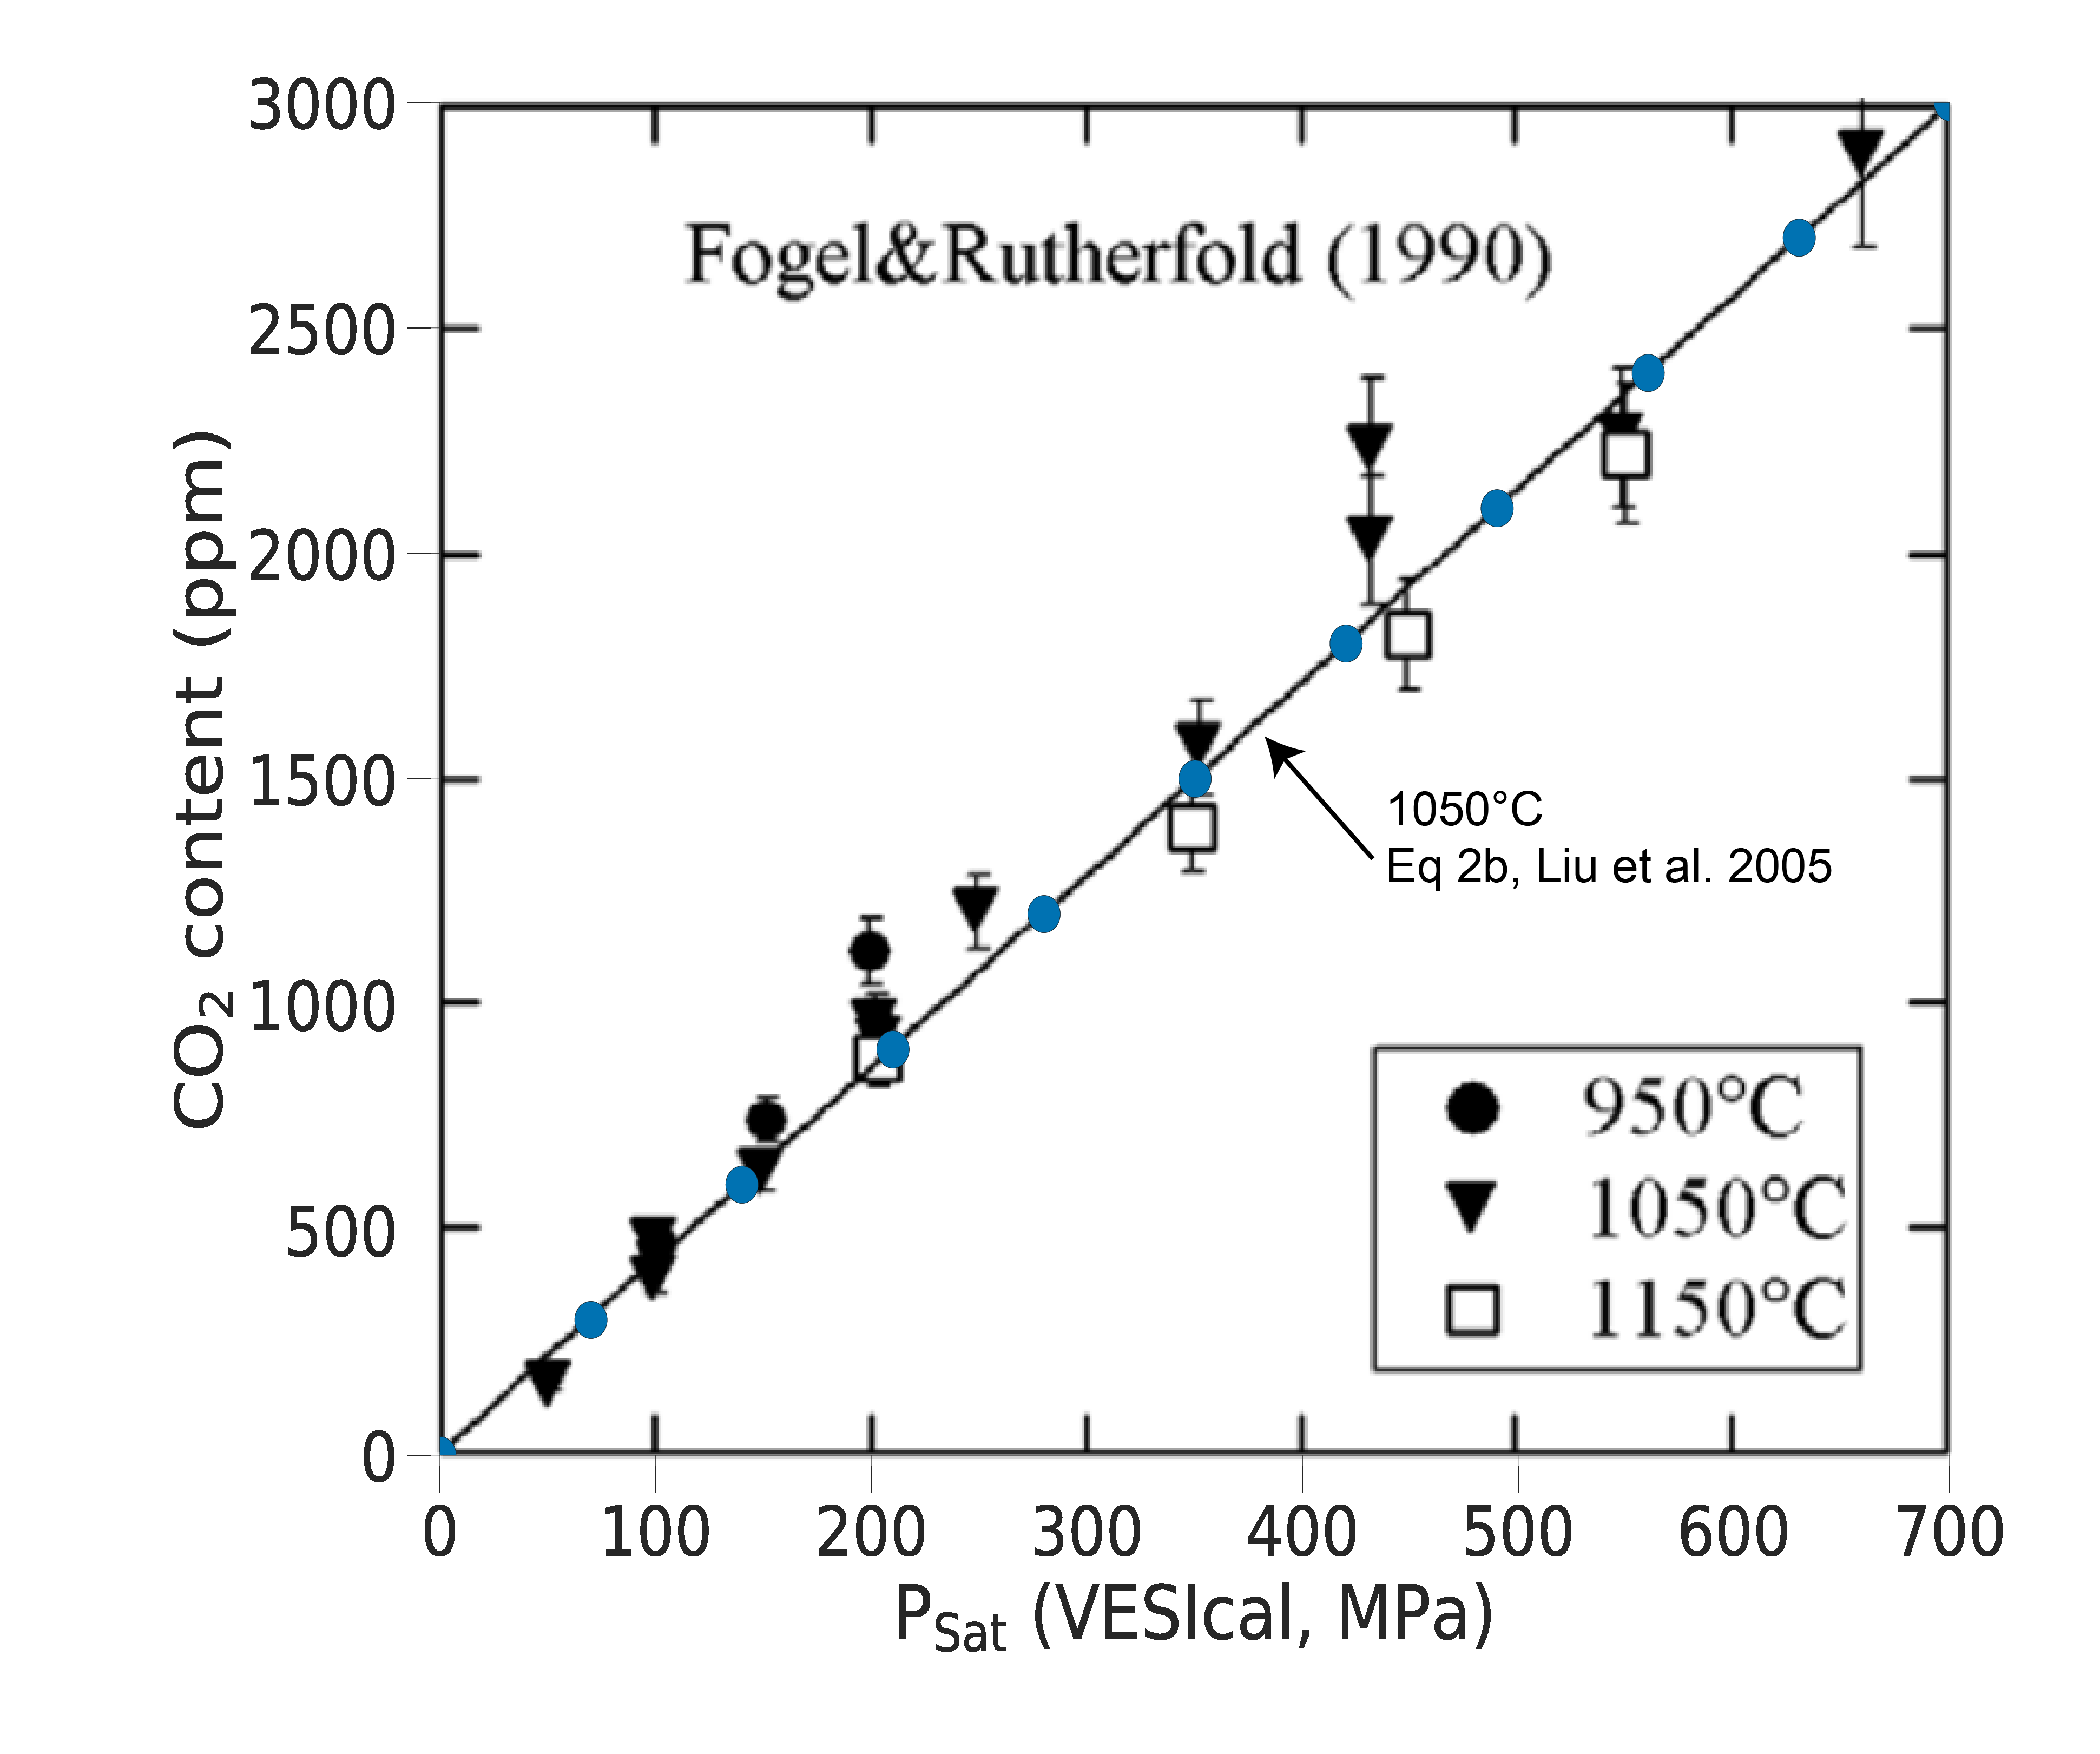


# Test 4  - Recreating isobars on their Fig.  6 plots

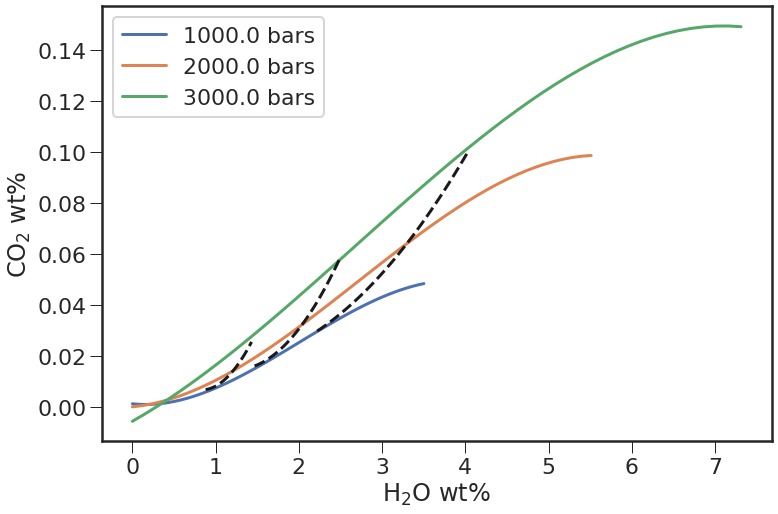

In [8]:
"""To get composition from a specific sample in the input data:"""
SampleName = 'Sample1'
bulk_comp = myfile.get_sample_oxide_comp(SampleName, norm='standard')

"""Define all variables to be passed to the function for calculating isobars and isopleths"""
"""Define the temperature in degrees C"""
temperature = 1050

"""Define a list of pressures in bars:"""
pressures = [1000.0, 2000, 3000]

isobars, isopleths = v.calculate_isobars_and_isopleths(sample=bulk_comp, model='Liu',
                                            temperature=temperature,
                                            pressure_list=pressures,
                                            isopleth_list=[0.25, 0.5, 0.1],
                                            print_status=True).result
v.plot_isobars_and_isopleths(isobars, isopleths)

Text(0, 0.5, 'CO2')

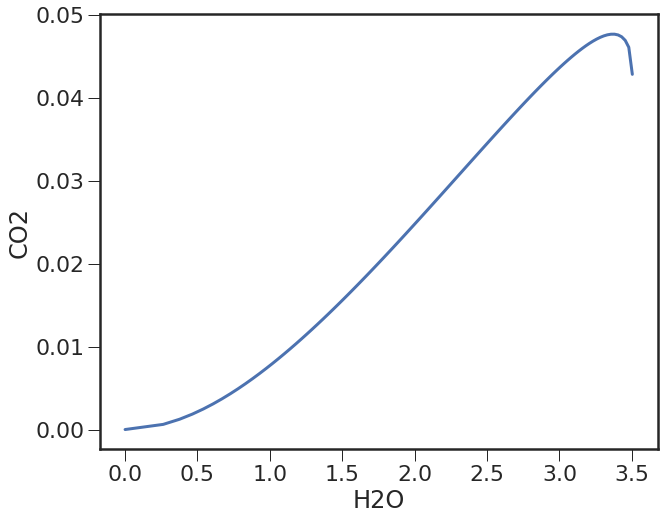

In [12]:
# Calculating 1000 bar isotherm
index1000bars=isobars["Pressure"]==1000
index2000bars=isobars["Pressure"]==2000
index3000bars=isobars["Pressure"]==3000
H2O=isobars["H2O_liq"]
CO2=isobars["CO2_liq"]
fig, ax1 = plt.subplots(figsize = (10,8))
plt.plot(H2O[index1000bars], CO2[index1000bars])
plt.xlabel('H2O')
plt.ylabel('CO2')

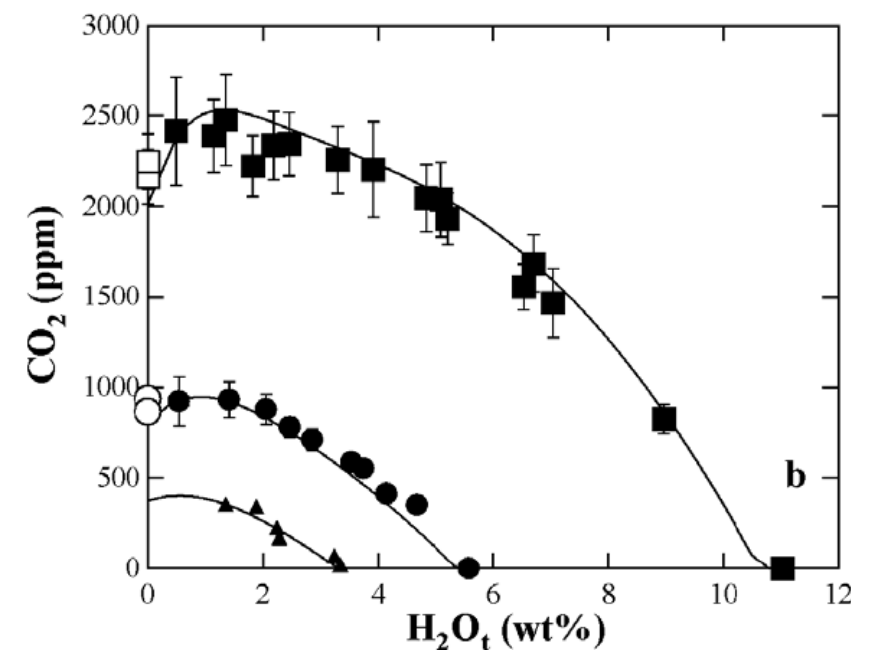
